In [1]:
using SharedArrays
using Distributions
using LinearAlgebra
@everywhere using LinearAlgebra

In [20]:
@assert (length(procs()) == 7) "expecting 6 cores / length 7 vector"

This notebook is a quick demonstration of some basic distributed computation using julia 1.0. Because we're performing Monte Carlo in this case, there is no interaction between cores, which makes things nice and easy. The only issues are ensuring that the relevant modules, functions and data are available to each core, and finding the right syntax for distributed for loops. I've only been using the language 3 days, and I have a *lot* of open questions about what is happening here, the below may not be optimal, but the important thing for me is that it appears to *work*. *Caveat emptor*.

## Testing Distributed Monte Carlo
This is an example I jacked from http://corysimon.github.io/articles/parallel-monte-carlo-in-julia/. Thanks! The syntax has changed slightly for 1.0 (although in retrospect, I think we have just moved from `@parallel` to `@distributed`. I've also used `@sync` to ensure that all cores have finished before we return. While the `@distributed (+)` accumulation could be used, I prefer spitting the output into arrays as below, because it is more general. For example, weighted means might be a simple extension which would require this additional control.

In [ ]:
@everywhere function compute_pi(N::Int)
    """
    Compute pi with a Monte Carlo simulation of N darts thrown in [-1,1]^2
    Returns estimate of pi
    """
    n_landed_in_circle = 0  # counts number of points that have radial coordinate < 1, i.e. in circle
    for i = 1:N
        x = rand() * 2 - 1  # uniformly distributed number on x-axis
        y = rand() * 2 - 1  # uniformly distributed number on y-axis

        r2 = x*x + y*y  # radius squared, in radial coordinates
        if r2 < 1.0
            n_landed_in_circle += 1
        end
    end

    return n_landed_in_circle / N * 4.0    
end

In [43]:
function distributed_pi(N, njobs)
    a = SharedArray{Float64}(njobs)

    @sync @distributed for i = 1:njobs
        a[i] = compute_pi(N)
    end;

    return a
end

function undistributed_pi(N, njobs)
    a = zeros(njobs)

    for i = 1:njobs
        a[i] = compute_pi(N)
    end;

    return a
end

distributed_pi (generic function with 1 method)

In [58]:
@time undistributed_pi(Int64(1e9), 6)

 17.303972 seconds (6 allocations: 304 bytes)


6-element Array{Float64,1}:
 3.14162768 
 3.141631156
 3.141615116
 3.141523724
 3.141535224
 3.141582056

In [61]:
@time a = distributed_pi(Int64(1e9), 6)

  4.767468 seconds (1.71 k allocations: 76.297 KiB)


6-element SharedArray{Float64,1}:
 3.141568044
 3.141509472
 3.141663312
 3.141605268
 3.141524756
 3.141635768

## Distributed Monte Carlo for Annealed Importance Sampling
This is a counterpart to the original notebook I made for Annealed Importance Sampling. Please see this for more details of the objective and the method.

In [3]:
# model definition
μ_init = [-2.,2.]
μ_target = [2.,0.]
L_init = LowerTriangular([1.0 0; 0.9  0.43589]) 
L_target = LowerTriangular([0.447214 0; -0.402492  0.194936])
Linv_init = LowerTriangular([2.29416 0; -2.06474  1.0])
Linv_target = LowerTriangular([5.12989 0; 4.6169  2.23607])


# hyper parameters
n_tempered = 100
betas = cumsum([pdf(Normal(0,1), x) for x in range(-3, stop=3, length=n_tempered)])
betas = betas/maximum(betas)
delta = 0.3
n_steps = 50


@everywhere function f_log_beta(x::Array{Float64,1}, beta::Float64)
    # ==> HOW DO I SHARE THE ABOVE DATA WITHOUT COPYING INTO FUNCTION? <====
    μ_init = [-2.,2.]
    μ_target = [2.,0.]
    Linv_init = LowerTriangular([2.29416 0; -2.06474  1.0])
    Linv_target = LowerTriangular([5.12989 0; 4.6169  2.23607])
    
    d_init = (x - μ_init)' * Linv_init
    d_target = (x - μ_target)' * Linv_target
    return - 0.5 * ( (1-beta) * sum(d_init.^2) + beta * sum(d_target.^2))
end

function annealed_importance_sample_gauss(n_samples, betas; steps, sqrtdelta)
    S = SharedArray{Float64}(n_samples, 2)
    W = SharedArray{Float64}(n_samples)
    R = SharedArray{Float64}(length(betas)-1)
    @sync @distributed for n = range(1, stop=n_samples)
        x = L_init * randn(2) + μ_init
        f_prev = f_log_beta(x, 0.0)
        w = 0
        r = zeros(length(betas)-1)

        for (i, beta) = enumerate(betas[2:end])
            w += f_log_beta(x, beta) - f_prev
            
            # Markov transition kernel
            # ------------------------
            for _ = 1:steps
                proposal = x + randn(2)*sqrtdelta

                A = exp(f_log_beta(proposal, beta) - f_log_beta(x, beta))

                if rand() < A
                    x = proposal
                else
                    r[i] += 1
                end
            end
            # ------------------------
            f_prev = f_log_beta(x, beta)
        end
        S[n,:] = x; W[n] = w; R += r
    end
        
    return S, exp.(W), R/(n_samples*steps)
end

annealed_importance_sample_gauss (generic function with 1 method)

In [13]:
@time S, W, R = annealed_importance_sample_gauss(Int64(4e4), betas, steps=n_steps, sqrtdelta=sqrt(delta))

225.800768 seconds (2.81 M allocations: 139.108 MiB, 0.02% gc time)


([2.1444 0.0793736; 2.88127 -1.10802; … ; 0.892796 1.18299; 1.8983 0.155356], [0.0289788, 0.225388, 0.539181, 0.123483, 0.0721795, 0.0284819, 0.741459, 0.537669, 0.262514, 0.0626333  …  0.085678, 0.00854079, 0.0267501, 0.0614773, 0.167848, 0.0126722, 0.31092, 0.159513, 0.112154, 0.0404594], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [7]:
using PyPlot
using Formatting

In [8]:
unpack_arr(x::Array{Float64,2}) = [x[:,i] for i in range(1,stop=size(x,2))]
unpack_arr(x::Adjoint{Float64,Array{Float64,2}}) = [x[:,i] for i in range(1,stop=size(x,2))]
hstack(x) = reduce(hcat, x)
vstack(x) = reduce(vcat, x)

function gaussian_2D_level_curve(mu::Array{Float64,1}, sigma::Array{Float64, 2}, alpha=2, ncoods=100)
    @assert size(mu) == (2,) "mu must be vector in R^2"
    @assert size(sigma) == (2, 2) "sigma must be 2x2 array"

    U, S, V = svd(sigma)

    sd = sqrt.(S)
    coods = range(0, stop=2*pi, length=ncoods)
    coods = hstack((sd[1] * cos.(coods), sd[2] * sin.(coods)))' * alpha
    
    coods = (V' * coods)' # project onto basis of ellipse
    coods = coods .+ mu' # add mean
    return coods
end;

In [9]:
function plot_is_vs_target(S, W; kwargs...)
    rgba_colors = zeros(size(S, 1), 4)
    rgba_colors[:, 3] .= 1.0   # blue
    rgba_colors[:, 4] = W/maximum(W)   # alpha
#     print(rgba_colors)
    ax = gca()
    ax[:plot](unpack_arr(gaussian_2D_level_curve(μ_target, L_target*L_target'))...; kwargs...);
    ax[:scatter](unpack_arr(S)..., c=rgba_colors)
end
    
function partition_error(S, W)
    partition_ratio = prod(diag(Linv_init))/prod(diag(Linv_target))
    partition_ratio_est = mean(W)
    println("Exact ratio = " * sprintf1("%.8f", partition_ratio) * "\nEstimated ratio = " * 
            sprintf1("%.8f", partition_ratio_est) * "\nError_pct = " * 
            sprintf1("%.2f", (partition_ratio_est/partition_ratio - 1)*100))
end

partition_error (generic function with 1 method)

In [14]:
S, W, R = [convert(Array{Float64}, x) for x in (S, W, R)];

In [15]:
partition_error(S, W)

Exact ratio = 0.20000012
Estimated ratio = 0.19987865
Error_pct = -0.06


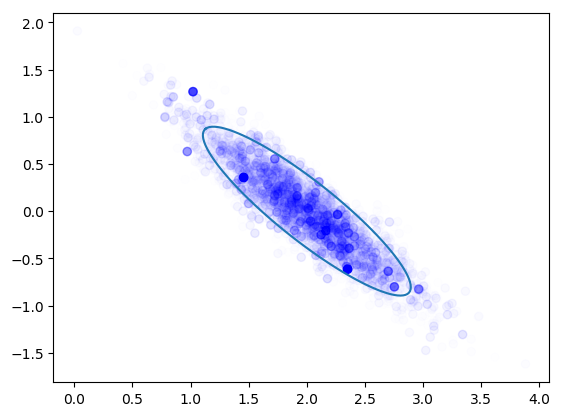

PyObject <matplotlib.collections.PathCollection object at 0xa46851a20>

In [127]:
plot_is_vs_target(S[1:8:Int(4e4),:], W[1:8:Int(4e4)])

## Should we care about the seeds in each core?

Well, the resulting numbers generated do appear to be unique, so we don't have the same problem as in Python where all cores are initialised to the same seed. However, since one imagines a clever strategy has not been used in order to do this, it may not work well. The `randjump` function can calculate (e.g.) seeds that are $10^{20}$ distance apart in state evolution of the RNG so numbers are in practice never going to overlap. This can be achieved via the following:

From the Julia `parallel-computing` docs, the following strategy is given, which is useful for multiple threads:
```julia
using Random; import Future
r = let m = MersenneTwister(1)
    [m; accumulate(Future.randjump, m, fill(big(10)^20, nthreads()-1))]
end;
```
However, we do not need to generate new RNGs (I don't think...?) we simply need to ensure that the state on each core is this distance apart. We can have a look at what the seeds currently are:

In [94]:
R = SharedArray{Float64}(nprocs()-1)
@sync @distributed for n = 1:(nprocs()-1)
    R[n] = convert(Int, Random.GLOBAL_RNG.seed[1])
end
R

6-element SharedArray{Float64,1}:
 3.830132258e9
 1.939900706e9
 2.630081062e9
 2.54959508e9 
 1.122892685e9
 1.57740951e8 

This is encouraging, but we don't (I think) have any guarantees on the distance in state between these RNGs. Ideally we would update the state, which can be calculated via the `randjump` function, but actually `randjump` spits out a new RNG. Perhaps we ought to overwrite the `Random.GLOBAL_RNG` for each core? I'm actually not really sure, so I'm going to stop here. One more word before I go, worth pointing out that `randjump` seems in a fairly unintuitive place, and furthermore, if we have certain Distributed types/methods imported (i.e. `Future`) we're going to have a clash. This can be resolved via:

In [95]:
using Future: randjump